In [2]:
from pet.utils import InputExample
import os
import json
from tqdm import tqdm
from collections import defaultdict
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
import torch

import logging
process_id = os.getpid()
logging.getLogger().setLevel(logging.INFO)
logging.basicConfig(level=logging.INFO,
                        format=str(
                            process_id) + ' - %(asctime)s %(filename)s[line:%(lineno)d] %(levelname)s %(message)s',
                        datefmt='%a, %d %b %Y %H:%M:%S')

# nohup python sweep_aug.py --dataset agnews --device 0 --train_examples 0 --test_examples -1 --unlabeled_examples -1 --method fedpet --client_num_in_total 32 --all_client_num_in_total 1000 --seed 6 --pattern_ids 1 --alpha 1 --data_point 5 --num_clients_infer 5 --infer_freq 1 &

def calculate_sentence_transformer_embedding(text_to_encode, mean=True):
    num = len(text_to_encode)
    emb_model = SentenceTransformer('sentence-transformers/paraphrase-mpnet-base-v2')
    embeddings = []
    # bar = tqdm(range(0,num,20),desc='calculate embeddings')
    for i in range(0,num,20):
        embeddings += emb_model.encode(text_to_encode[i:i+20]).tolist()
        # bar.update(1)
    embeddings = torch.tensor(embeddings)
    mean_embeddings = torch.mean(embeddings, 0, True)
    if mean:
        embeddings = embeddings - mean_embeddings
    else:
        embeddings = embeddings
    return embeddings

def text_to_encode(train_examples, dataset):
    if dataset == "agnews":
        return ["{}(){}".format(raw_item.to_dict()["text_a"], raw_item.to_dict()["text_b"]) for raw_item in train_examples]
    elif dataset == "mnli":
        return ["{}.\nquestion: {}".format(raw_item.to_dict()["text_a"], raw_item.to_dict()["text_b"]) for raw_item in train_examples]
    elif dataset == "yahoo":
        return ["question: {}.\nanswer: {}".format(raw_item.to_dict()["text_a"], raw_item.to_dict()["text_b"]) for raw_item in train_examples]
    elif dataset == "yelp-full":
        return ["{}".format(raw_item.to_dict()["text_a"]) for raw_item in train_examples]
    else:
        raise ValueError("dataset not supported")

def select_by_sorting(labeled_example, unlabeled_examples, select_num, dataset):
    if len(labeled_example) == 0:
        logging.info("no labeled example, select randomly")
        labeled_example = unlabeled_examples[0:1]
        unlabeled_examples = unlabeled_examples[1:]
    all_train_text_to_encode = text_to_encode(list(unlabeled_examples), dataset)
    embeddings = calculate_sentence_transformer_embedding(text_to_encode=all_train_text_to_encode,mean=False)
    unlabeled_embeddings = embeddings
    all_train_text_to_encode = text_to_encode(list(labeled_example), dataset)
    embeddings = calculate_sentence_transformer_embedding(text_to_encode=all_train_text_to_encode,mean=False)
    labeled_embeddings = embeddings
    # logging.info(f"unlabeled_embeddings: {unlabeled_embeddings}, labeled_embeddings: {labeled_embeddings}")
    # labeled_embeddings = labeled_embeddings.reshape(1, -1)
    # logging.info(f"After reshaping, labeled_embeddings: {labeled_embeddings}")
    logging.info("Compute cosin_similarity.")
    similarity = cosine_similarity(unlabeled_embeddings, labeled_embeddings)
    # logging.info(f"similarity shape: {similarity.shape}, similarity: {similarity}")
    similarity = np.mean(similarity, axis=1)
    # logging.info(f"After np.mean(): similarity shape: {similarity.shape}, similarity: {similarity}")
    selected_indices = np.argsort(similarity)[-select_num:]
    selected_examples = []
    for idx in selected_indices:
        selected_examples.append(unlabeled_examples[idx])
    return selected_examples

def select_by_voting(train_examples, select_num, output_dir, dataset, k = 150):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    vote_file=os.path.join(output_dir,'votek_cache.json')

    if vote_file is not None and os.path.isfile(vote_file): # will load from json file if exists.
        logging.info(f'load from {vote_file}')
        embeddings=[]
    else:
        all_train_text_to_encode = text_to_encode(list(train_examples), dataset)
        embeddings = calculate_sentence_transformer_embedding(text_to_encode=all_train_text_to_encode)

    selected_indices = fast_votek(embeddings=embeddings,
                                  select_num=select_num,
                                  k=k,
                                  vote_file=os.path.join(output_dir,'votek_cache.json'))
    selected_examples = []
    for idx in selected_indices:
        selected_examples.append(train_examples[idx])
    return selected_indices, selected_examples

def fast_votek(embeddings,select_num,k,vote_file=None):
    n = len(embeddings)
    if vote_file is not None and os.path.isfile(vote_file):
        with open(vote_file) as f:
            vote_stat = json.load(f)
    else:
        # bar = tqdm(range(n),desc=f'voting')
        vote_stat = defaultdict(list)
        for i in range(n):
            cur_emb = embeddings[i].reshape(1, -1)
            # logging.info("Compute cosin_similarity.")
            cur_scores = np.sum(cosine_similarity(embeddings, cur_emb), axis=1)
            sorted_indices = np.argsort(cur_scores).tolist()[-k-1:-1]
            for idx in sorted_indices:
                if idx!=i:
                    vote_stat[idx].append(i) # idx （与i最相似的150个样本之一）的 vote_stat 里面加入 i作为相似的样本
            # logging.info(i)
            # bar.update(1)
        if vote_file is not None:
            with open(vote_file,'w') as f:
                json.dump(vote_stat,f)
        logging.info(f'voting done, saved into {vote_file}')
    votes = sorted(vote_stat.items(),key=lambda x:len(x[1]),reverse=True) # 按照拥有相似样本的数量来排序
    logging.info(f'sorted votes')
    selected_indices = []
    selected_times = defaultdict(int)
    while len(selected_indices)<select_num:
        cur_scores = defaultdict(int)
        # logging.info(f'len(selected_indices)={len(selected_indices)}')
        for idx,candidates in votes:
            if idx in selected_indices:
                cur_scores[idx] = -100
                continue
            for one_support in candidates:
                if not one_support in selected_indices:
                    cur_scores[idx] += 10 ** (-selected_times[one_support]) # if one_support not been selected, add 1, or add **.
        cur_selected_idx = max(cur_scores.items(),key=lambda x:x[1])[0] # discourage idx that has been selected to encourage diversity.
        selected_indices.append(int(cur_selected_idx))
        for idx_support in vote_stat[cur_selected_idx]: # 与cur_selected_idx相关的样本的selected_times加1，support越多，权重越低，越不容易被选中
            selected_times[idx_support] += 1
    return selected_indices

The Zen of Python, by Tim Peters

Beautiful is better than ugly.
Explicit is better than implicit.
Simple is better than complex.
Complex is better than complicated.
Flat is better than nested.
Sparse is better than dense.
Readability counts.
Special cases aren't special enough to break the rules.
Although practicality beats purity.
Errors should never pass silently.
Unless explicitly silenced.
In the face of ambiguity, refuse the temptation to guess.
There should be one-- and preferably only one --obvious way to do it.
Although that way may not be obvious at first unless you're Dutch.
Now is better than never.
Although never is often better than *right* now.
If the implementation is hard to explain, it's a bad idea.
If the implementation is easy to explain, it may be a good idea.
Namespaces are one honking great idea -- let's do more of those!


In [3]:
p = os.path.join("/Users/cdq/Desktop/opensource/FedPrompt/data/ablation/filter/train.bin")
ipet_data = InputExample.load_examples(p)

show = 392

ipet_data = np.random.choice(ipet_data,show)


In [4]:
ipet_data

array([{
         "guid": "train-100414",
         "idx": -1,
         "label": "neutral",
         "logits": null,
         "meta": {},
         "text_a": "Get details from the city tourist office on the eight-hour trip, which goes in either direction on alternate days, optional return by bus, from March October.",
         "text_b": "Most people say that the trip is worth it."
       }                                                                                                                                                                            ,
       {
         "guid": "train-343584",
         "idx": -1,
         "label": "neutral",
         "logits": null,
         "meta": {},
         "text_a": " Praise be to Mother Ganga! ",
         "text_b": "Praise to Mother Ganga for her recent blessings!"
       }                                                             ,
       {
         "guid": "train-145053",
         "idx": -1,
         "label": "neutral",
         "logits

In [5]:
# label = ['entailment', 'contradiction', 'neutral']
entailment_list = [x for x in list(ipet_data) if x.label=='entailment']
contradiction_list = [x for x in list(ipet_data) if x.label=='contradiction']
neutral_list = [x for x in list(ipet_data) if x.label=='neutral']
not_entailment_list = [x for x in list(ipet_data) if x.label!='entailment']

In [6]:
entailment_embeddings = calculate_sentence_transformer_embedding(text_to_encode=text_to_encode(list(entailment_list), 'mnli'))
not_entailment_embeddings = calculate_sentence_transformer_embedding(text_to_encode=text_to_encode(list(not_entailment_list), 'mnli'))
embeddings = calculate_sentence_transformer_embedding(text_to_encode=text_to_encode(list(ipet_data), 'mnli'))

10514 - Thu, 08 Dec 2022 21:56:06 SentenceTransformer.py[line:66] INFO Load pretrained SentenceTransformer: sentence-transformers/paraphrase-mpnet-base-v2
10514 - Thu, 08 Dec 2022 21:56:07 SentenceTransformer.py[line:105] INFO Use pytorch device: cpu
Batches: 100%|██████████| 1/1 [00:01<00:00,  1.57s/it]
10514 - Thu, 08 Dec 2022 21:56:23 SentenceTransformer.py[line:66] INFO Load pretrained SentenceTransformer: sentence-transformers/paraphrase-mpnet-base-v2
10514 - Thu, 08 Dec 2022 21:56:24 SentenceTransformer.py[line:105] INFO Use pytorch device: cpu
Batches: 100%|██████████| 1/1 [00:01<00:00,  1.54s/it]
10514 - Thu, 08 Dec 2022 21:57:01 SentenceTransformer.py[line:66] INFO Load pretrained SentenceTransformer: sentence-transformers/paraphrase-mpnet-base-v2
10514 - Thu, 08 Dec 2022 21:57:01 SentenceTransformer.py[line:105] INFO Use pytorch device: cpu
Batches: 100%|██████████| 1/1 [00:01<00:00,  1.16s/it]


In [7]:
entailment_embeddings_mean = entailment_embeddings.mean(axis=0)
not_entailment_embeddings_mean = not_entailment_embeddings.mean(axis=0)

In [8]:
# entailment 
x = np.array(cosine_similarity(embeddings, entailment_embeddings_mean.reshape(1, -1)))*10

# not entailment
y = np.array(cosine_similarity(embeddings, not_entailment_embeddings_mean.reshape(1, -1)))*10


In [36]:
text = text_to_encode(list(ipet_data), 'mnli')
text

['Get details from the city tourist office on the eight-hour trip, which goes in either direction on alternate days, optional return by bus, from March October..\nquestion: Most people say that the trip is worth it.',
 ' Praise be to Mother Ganga! .\nquestion: Praise to Mother Ganga for her recent blessings!',
 'In crafting GPRA, Congress recognized that federal agencies do not exist in a vacuum..\nquestion: The agencies had to operate within the boundaries of other agencies.',
 "so that's real good.\nquestion: The news is wonderful.",
 'Another bandwidth initiative, Broadcast PC , will exploit the unused bandwidth in broadcast television signals to beam content..\nquestion: There is no unused bandwidth available.',
 "I don't know, said Adrin..\nquestion: Adrin said he didn't know about the villagers' plans.",
 "uh or maybe eventually uh just waiting it out and that's where a lot of aggravation comes i think is is uh these guys spend so much time in the appeal process or just in the wa

In [35]:
list_data = np.array([x.T[0], y.T[0]]).T
list_data
print("similarity",[t for t in list_data if abs(t[0]) < 0.01 and abs(t[1]) < 0.1])

print("index",[t for t in range(len(list_data)) if abs(list_data[t][0]) < 0.01 and abs(list_data[t][1])<0.1] )


similarity [array([0.00491949, 0.02417814], dtype=float32), array([-0.00786096, -0.04839525], dtype=float32), array([-0.00927351,  0.0442108 ], dtype=float32)]
index [71, 260, 293]
samle


In [37]:
print(text[71])

Branded, service-driven, globalized, and unhindered by the state, the Las Vegas casinos do sound uncannily like models for the economy into which we appear to be moving..
question: The model economy of Las Vegas casinos has never been a model of our economy.


In [38]:
print(text[260])

Even without Leonardo da Vinci's masterpiece in the adjoining refectory, the church of Santa Maria delle Grazie (Via Caradosso, southwest of the Cetello) would be worth a visit as a jewel of Renaissance architecture..
question: The church of Santa Maria delle Grazie is very plain.


In [40]:
print(text[293])

They tell me this is easy work compared to the type they had to undergo..
question: My work is one hundred times harder than anyone else's.


10514 - Thu, 08 Dec 2022 22:09:32 <ipython-input-2-7fbaa99c6f79>[line:81] INFO load from ./filter_data/votek_cache.json
10514 - Thu, 08 Dec 2022 22:09:32 <ipython-input-2-7fbaa99c6f79>[line:119] INFO sorted votes


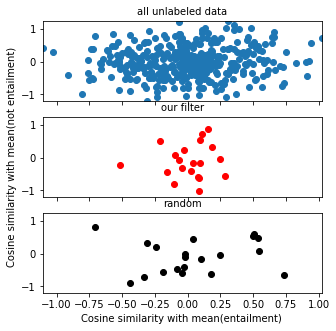

In [33]:

select_num = 20
selected_index, out_put_data = select_by_voting(ipet_data, select_num, './filter_data', 'mnli', k = 30)

from matplotlib import pyplot as plt

random_index = np.random.choice(len(ipet_data), select_num, replace=False)

fig, ax = plt.subplots(3, 1, sharex='col',figsize=(5,5))
plt.xlabel("Cosine similarity with mean(entailment) ") 

ax[0].set_title('all unlabeled data', fontsize=10)
ax[0].set_xlim(min(x),max(x))
ax[0].set_ylim(min(y),max(y))
ax[0].scatter(x,y, label='all')

ax[1].set_title('our filter', fontsize=10)
ax[1].set_xlim(min(x),max(x))
ax[1].set_ylim(min(y),max(y))
ax[1].scatter([x[i] for i in selected_index], [y[i] for i in selected_index] , color = 'red', label='filtered')
ax[1].set_ylabel("Cosine similarity with mean(not entailment)")

ax[2].set_title('random', fontsize=10)
ax[2].set_xlim(min(x),max(x))
ax[2].set_ylim(min(y),max(y))
ax[2].scatter([x[i] for i in random_index], [y[i] for i in random_index] , color = 'black',label='black')

plt.savefig('filter.pdf', dpi=300, bbox_inches='tight')

7464 - Sun, 04 Dec 2022 09:19:13 <ipython-input-236-7fbaa99c6f79>[line:81] INFO load from ./filter_data/votek_cache.json
7464 - Sun, 04 Dec 2022 09:19:13 <ipython-input-236-7fbaa99c6f79>[line:119] INFO sorted votes


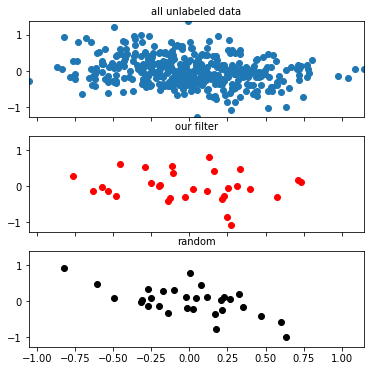

In [243]:

select_num = 30
selected_index, out_put_data = select_by_voting(ipet_data, select_num, './filter_data', 'mnli', k = 30)

from matplotlib import pyplot as plt

random_index = np.random.choice(len(ipet_data), select_num, replace=False)


fig, ax = plt.subplots(3, 1, sharex='col',figsize=(6,6))
ax[0].set_title('all unlabeled data', fontsize=10)
ax[0].set_xlim(min(x),max(x))
ax[0].set_ylim(min(y),max(y))
ax[0].scatter(x,y, label='entailment')

ax[1].set_title('our filter', fontsize=10)
ax[1].set_xlim(min(x),max(x))
ax[1].set_ylim(min(y),max(y))
ax[1].scatter([x[i] for i in selected_index], [y[i] for i in selected_index] , color = 'red', label='red')

ax[2].set_title('random', fontsize=10)
ax[2].set_xlim(min(x),max(x))
ax[2].set_ylim(min(y),max(y))
ax[2].scatter([x[i] for i in random_index], [y[i] for i in random_index] , color = 'black',label='black')

plt.savefig('filter.pdf', dpi=300, bbox_inches='tight')

7464 - Sun, 04 Dec 2022 09:19:13 <ipython-input-236-7fbaa99c6f79>[line:81] INFO load from ./filter_data/votek_cache.json
7464 - Sun, 04 Dec 2022 09:19:13 <ipython-input-236-7fbaa99c6f79>[line:119] INFO sorted votes


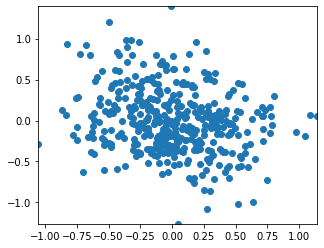

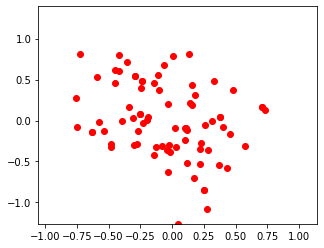

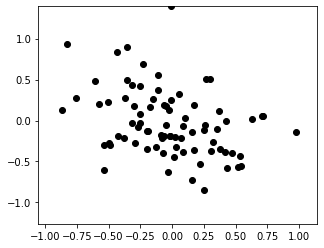

In [244]:

select_num = 80
selected_index, out_put_data = select_by_voting(ipet_data, select_num, './filter_data', 'mnli', k = 30)

from matplotlib import pyplot as plt

random_index = np.random.choice(len(ipet_data), select_num, replace=False)

fig = plt.figure(figsize=(5, 4))
plt.xlim(min(x),max(x))
plt.ylim(min(y),max(y))
plt.scatter(x,y, label='entailment')

fig = plt.figure(figsize=(5, 4))
plt.xlim(min(x),max(x))
plt.ylim(min(y),max(y))
plt.scatter([x[i] for i in selected_index], [y[i] for i in selected_index] , color = 'red', label='red')

fig = plt.figure(figsize=(5, 4))
plt.xlim(min(x),max(x))
plt.ylim(min(y),max(y))
plt.scatter([x[i] for i in random_index], [y[i] for i in random_index] , color = 'black',label='black')

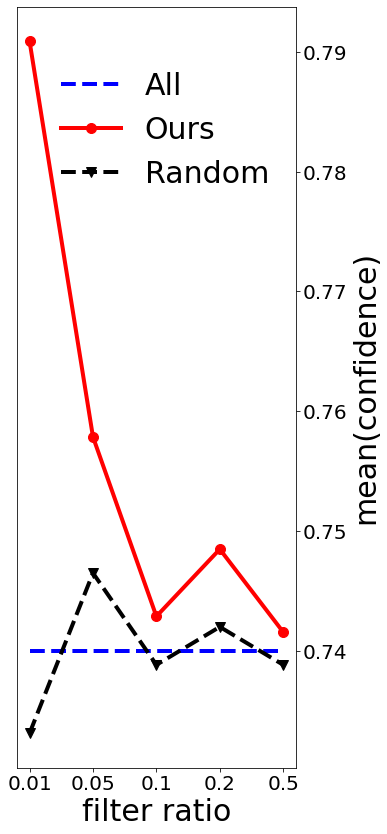

In [311]:
# mnli:filter_0.1 normal ipet: 0.7420202277159482, vote k: 0.7457432522796668
# mnli:filter_0.2 normal ipet: 0.6858990423692045, vote k: 0.6885280676158794
# mnli:filter_0.5 normal ipet: 0.6943051423925227, vote k: 0.6944262939774419
# mnli:filter_0.05 normal ipet: 0.887411199811504, vote k: 0.87468074001764
# mnli:filter_1 normal ipet: 0.7331490549622548, vote k: 0.7332269577512868

# mnli:filter 0.1 normal ipet: 0.7465110163071326, vote k: 0.7428971243210327
# mnli:filter 0.2 normal ipet: 0.7388538545491744, vote k: 0.7485007323133639
# mnli:filter 0.5 normal ipet: 0.7388538545491744, vote k: 0.7415846921503543
# mnli:filter 0.01 normal ipet: 0.7921842163162571, vote k: 0.7908667941888173
# mnli:filter 0.05 normal ipet: 0.7681504223039564, vote k: 0.7578628395733081

votek = [0.7908667941888173, 0.7578628395733081, 0.7428971243210327, 0.7485007323133639, 0.7415846921503543]
random = [0.7331490549622548, 0.7465110163071326, 0.7388538545491744, 0.7420202277159482, 0.738853853071326]

x = [0.01, 0.05, 0.1, 0.2, 0.5]
plt.figure(figsize=(5, 14))
plt.ylabel("mean(confidence)",fontsize=30,)
plt.xlabel('filter ratio',fontsize=30)
ax = plt.gca()
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")


plt.hlines(0.74, 0, 4, colors = "b", linestyles = "dashed", label='All', linewidth=4)
plt.plot(range(len(x)), votek, label='Ours', color='r',marker='o', markersize=10, linewidth=4)
plt.plot(range(len(x)), random, label='Random', color = "k", marker='v', linestyle = "--", markersize=10, linewidth=4)

plt.xticks(range(len(x)),x,fontsize=20)
plt.yticks(fontsize=20)

plt.legend(fontsize=30, loc='upper right', bbox_to_anchor=(1.0, 0.95), frameon=False)
plt.savefig("/Users/cdq/Desktop/opensource/FedPrompt/figs/ablation/filter/mnli-confidence-different-ratio-vertical.pdf", dpi=300, bbox_inches='tight')